-changelog
v19 10/30/24
+ testing different rotations for timeseries
v20- 11/10/24 with new taco run (new 0.1 df abs thershold value for spike dewtection
v23- 12/7/24- additional streamlining, attempt to include UMAP
v23_local only- 12/18- local copy completed to run on jupyter labs
v29- 4/1/25- removed extraneous plots. 

## Setup


In [ ]:
from pathlib import Path
import os
import notebook_setup
info = notebook_setup.setup()
# Environment & Imports Setup
import matplotlib as matplotlib
#code ocean step
use_code_ocean = True
if use_code_ocean:
    matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import pandas as pd
import random
import datetime
import pingouin as png
from scipy.stats import chi2_contingency
%matplotlib inline 
print(f"matplotlib {matplotlib.__version__} | Seaborn {sns.__version__}")
warnings.filterwarnings(action='ignore', category=FutureWarning)
pd.set_option('mode.use_inf_as_na', False) # pd.set_option('future.no_silent_downcasting', True)
np.random.seed(1) #set seed for reproducibility 
random.seed(1)
# Apply mplstyle via absolute path from setup info
style_path = Path(info["function_py_storage"]) / "paper_plot.mplstyle"
print(f"Loading style guide at {style_path}")
if style_path.is_file():
    plt.style.use(str(style_path))
else:
    print(f"[warn] Style not found at: {style_path}")
here = info["repo_root"]
print(f" Here: {here}")
_plot_posthoc_src = os.path.join(here, 'plot_posthoc_test', 'src')
if os.path.isdir(_plot_posthoc_src) and _plot_posthoc_src not in sys.path:
    sys.path.append(_plot_posthoc_src)
#custom function import
import custom_module_imports as cmi 
from preprocess_data import hyper_param_dict
from helper_functions import save_fig_in_main_fig_dir,  save_plot_record_as_csv_txt 
from ax_modifier_functions import set_ax_title_xlabel_ylabel, set_pointplot_edgecolor, set_labels
from sns_plotting_config import * #import dicts containing default plot params
from plot_posthoc_test.plot_stat_annotate import *
from dimension_reduce import *
from sklearn.manifold import TSNE
date_tag = "_".join([datetime.now().strftime('%d'),datetime.now().strftime('%h'),datetime.now().strftime('%Y')])

##Set/create save and load folder paths 
results_location = Path(here).parents[0] / "results"
data_location = Path(here).parents[0] / "data"
make_folder(results_location)
make_folder(data_location)
print(f"Saving results in {results_location}. Data location is {data_location}")
csv_folder_most_recent = results_location/ f"analysis_CSV_output/" #folders that analysis output goes to
make_folder( csv_folder_most_recent)

matplotlib 3.7.0 | Seaborn 0.12.1
Loading style guide at c:\Users\13car\Dropbox\local_github_repos_personal\dlx56_mPFC_1p_SohalLab\code\Function .py Storage\paper_plot.mplstyle
 Here: c:\Users\13car\Dropbox\local_github_repos_personal\dlx56_mPFC_1p_SohalLab\code
The folder 'c:\Users\13car\Dropbox\local_github_repos_personal\dlx56_mPFC_1p_SohalLab\results' already exists.
The folder 'c:\Users\13car\Dropbox\local_github_repos_personal\dlx56_mPFC_1p_SohalLab\data' already exists.
Saving results in c:\Users\13car\Dropbox\local_github_repos_personal\dlx56_mPFC_1p_SohalLab\results. Data location is c:\Users\13car\Dropbox\local_github_repos_personal\dlx56_mPFC_1p_SohalLab\data
The folder 'c:\Users\13car\Dropbox\local_github_repos_personal\dlx56_mPFC_1p_SohalLab\results\analysis_CSV_output' has been created.


<Figure size 960x720 with 0 Axes>

#### Import dataset

In [2]:
#declare loc/names of files to read
trial_df_filename = data_location /  f"Dlx56_Normalized Trial Calcium Timeseries_20_Jun_2025.parquet"
trial_tseries_df_norm = pd.read_parquet(trial_df_filename)
stage_col = 'task_phase_vec'
stage_names = sorted(trial_tseries_df_norm['task_phase_vec'].unique())#hardcode the stage_names (to not rely on the order of the 'unique() vector of the df
numeric_col = cmi.pp.get_numeric_cols_timeseries(trial_tseries_df_norm, " to ")
unit_mean_tseries =  cmi.pp.get_unit_mean_timeseries_by_phase(trial_tseries_df_norm,['trial_num'], ['name', 'neuron_ID','geno_day', stage_col], numeric_col) 
subject_stage_info_df = cmi.pp.get_subject_stage_info_df(trial_tseries_df_norm) # get subj level dfs
n_total_units = unit_mean_tseries.groupby(by = 'geno_day')['unique_ID'].nunique()
subject_stage_info_df.sample()

,name,geno_day,task_phase_vec,unique_ID,num_enriched_units,num_units,trial_num,count_of_trials,over_5
174,7_6_HET_RS2,Het CLNZ,Early_IA_Error,"[7_6_HET_RS2-10, 7_6_HET_RS2-20, 7_6_HET_RS2-2...",12,107,"[2, 3, 5]",3,"[False, False, False]"


In [3]:
# outcome_post = pd.read_csv(post_activity_timeseries, header =0,low_memory=False)
# cols_to_drop = ['threshold_with_shuffle','peak_dff_threshold_percentile','drop_low_value_peak_events','cutoff_filter','peak_event_cutoff_percentile']
# outcome_post =outcome_post.drop([x for x in cols_to_drop if x in outcome_post], axis = 1).dropna(subset = ['task_phase_vec'])
# annotate_csv(outcome_post, 'name')
# outcome_post = cmi.pp.bin_rotate_timeseries(outcome_post, window_size = hyper_param_dict['window_to_bin'], rotate_by =  hyper_param_dict['n_sec_to_rotate'])
# outcome_post.tail()

#### Create mean activity matrix for visualization

In [4]:
##Define functions to use for activity matrix creation
def get_df_unit_mean_activity_matrix(unit_mean_tseries, stage_names, numeric_col, ignore_pre):
    all_geno_matrix,  all_geno_IDs= get_unit_mean_phase_activity_matrix( unit_mean_tseries, False, stage_names, numeric_col, ignore_pre)
    mean_AV_matrix = pd.DataFrame(data =np.nanmean(all_geno_matrix, axis = 1), columns = stage_names, index = all_geno_IDs).merge(
        unit_mean_tseries.groupby('unique_ID')['geno_day'].first().to_frame(),left_index = True, right_on = 'unique_ID')
    if np.nanmean(mean_AV_matrix.loc[:, stage_names].sum(axis = 1) == 0)>0:
        mean_AV_matrix = mean_AV_matrix.loc[(mean_AV_matrix.loc[:, stage_names].sum(axis = 1) > 0),:]
    return mean_AV_matrix
## preprocessing and normalization steps
def get_unit_mean_phase_activity_matrix(unit_mean_tseries, use_enrich_unit_only, stage_names, numeric_col, ignore_pre):
    '''#TO- create matrix that's = concatenated vectors of all neuron mean activationni phase (output matrix = # units x # phases)    OUTPUT- '''
    matrix_IDs, stack_matrix,nan_df_list = dict(), dict(),[]
    skip_rec = dict()
    ## if going to skip pre-outcome period, change what counts as numeric col
    if ignore_pre:
        numeric_col = [col for col in numeric_col if '-' not in col]
    for dataset in unit_mean_tseries.name.unique():
        matrix_list = []
        dataset_df = unit_mean_tseries.loc[ (unit_mean_tseries.name == dataset),:]
        if len(dataset_df.task_phase_vec.unique()) < len(stage_names):#check that dataset has ALL 6 phases, if not, skip
            skip_rec[dataset] = len(dataset_df.task_phase_vec.unique())
            # continue
        for stage in stage_names:
            phase_mask = (dataset_df.task_phase_vec == stage)
            matrix = dataset_df.loc[phase_mask, numeric_col].values #get phase entries, producing (dataset_neuron) x (time_bin matrix)
            #check if phase is present, if matrix extracted w phase trials is empty, assume mous elacks it
            if matrix.shape[0] == 0:
                matrix = np.tile(np.nan, (len(dataset_df.unique_ID.unique()), len(numeric_col)))
            if np.sum(np.isnan(matrix))>0:
                nan_df_list.append( dataset_df.loc[phase_mask, numeric_col])
            matrix_list.append(matrix)
        stack_matrix[dataset] = np.dstack(matrix_list)
        matrix_IDs[dataset] = dataset_df.loc[phase_mask, 'unique_ID'].values
    all_geno_matrix = np.concatenate([val for val in stack_matrix.values()], axis = 0)
    all_geno_IDs =  np.concatenate([val for val in matrix_IDs .values()], axis = 0)
    return all_geno_matrix, all_geno_IDs

## extract tseries of interest to create AV matrix

AV_matrix = get_df_unit_mean_activity_matrix(unit_mean_tseries.drop('neuron_ID', axis = 1), stage_names, numeric_col, ignore_pre =True) # other way will not work: # AV_matrix =  get_df_unit_mean_activity_matrix(trial_tseries_df, stage_names, numeric_col)
AV_matrix['max_phase'] =AV_matrix[stage_names].idxmax(axis = 'columns')
max_95th_quantile = round(AV_matrix[stage_names].quantile(q = 0.95).max(),2)
min_5th_quantile = round(AV_matrix[stage_names].quantile(q = 0.05).min(),2)
print(f"5th percentile mean activation: {min_5th_quantile}, 95th percentile: {max_95th_quantile}")
WT_mask = AV_matrix.geno_day == "WT VEH"
AV_matrix['max_phase_val'] =AV_matrix.apply(lambda x: x[x.max_phase], axis = 1)
no_Early_IA_Error = AV_matrix.Early_IA_Error.isna()
has_Early_IA_Error = ~no_Early_IA_Error
AV_matrix.tail()

5th percentile mean activation: 0.0, 95th percentile: 0.21


C:\Users\13car\AppData\Local\Temp\ipykernel_11764\3026530803.py:4: RuntimeWarning: Mean of empty slice
  mean_AV_matrix = pd.DataFrame(data =np.nanmean(all_geno_matrix, axis = 1), columns = stage_names, index = all_geno_IDs).merge(


,Early_IA_Correct,Early_IA_Error,Early_RS_Correct,Early_RS_Error,Late_IA,Late_RS,geno_day,max_phase,max_phase_val
unique_ID,,,,,,,,,
9_3_HET_RS3-209,0.000000,0.050833,0.000000,0.00,0.000000,0.005000,Het postCLNZ,Early_IA_Error,0.050833
9_3_HET_RS3-212,0.141111,0.476667,0.036667,0.13,0.000000,0.012500,Het postCLNZ,Early_IA_Error,0.476667
9_3_HET_RS3-213,0.013333,0.005000,0.000000,0.00,0.009333,0.000000,Het postCLNZ,Early_IA_Correct,0.013333
9_3_HET_RS3-214,0.000000,0.000000,0.000000,0.00,0.000000,0.050000,Het postCLNZ,Late_RS,0.050000
9_3_HET_RS3-215,0.000000,0.000000,0.000000,0.00,0.000000,0.021875,Het postCLNZ,Late_RS,0.021875


In [5]:
enrichment_matrix = unit_mean_tseries.groupby(by = 'unique_ID')[['geno_day']+ stage_names].first()
tsne_results= {}
for geno_count, geno in enumerate(geno_order_w_WT_CLNZ):
    geno_AVs = AV_matrix.loc[AV_matrix.geno_day ==geno , stage_names].dropna()
    tsne_results[geno]=return_TSNE_on_stage_AV_w_enrich_labels(geno_AVs, enrichment_matrix, stage_names) # tsne_params = {'n_components': 2, "perplexity": 90, "method":'exact', 'init':'pca'}

## Supplementary Figure 1 plots

#### Supplement Figure 1B- # of cells per subject

C:\Users\13car\AppData\Local\Temp\ipykernel_11764\2393112375.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([x.get_text().replace(" ", "\n") for x in ax.get_xticklabels()])


The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\supp_fig_2' already exists.
The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\supp_fig_2\28_Aug_2025' already exists.


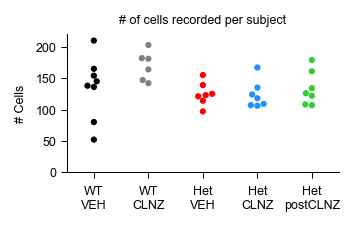

In [6]:
fig, ax = plt.subplots(1,1, figsize=(2.25,1.4), layout = 'constrained')
sns.swarmplot(data = subject_stage_info_df.groupby(['name','geno_day'])['num_units'].max().reset_index(),
              x = 'geno_day', y = 'num_units', order = geno_order_w_WT_CLNZ, legend = False, s = 3,**geno_order_w_WT_CLNZ_no_eb)
set_labels(ax, label_dict = dict(title =  f"# of cells recorded per subject", ylim = [0,220],xlabel=None, ylabel= f"# Cells"))
ax.set_xticklabels([x.get_text().replace(" ", "\n") for x in ax.get_xticklabels()])
save_fig_in_main_fig_dir(fig,fig_name = "Number of cells per subj by geno-day", folder_key='s_2', filetypes_to_save = ['png','svg'])

#### Supplement Figure 1C- % of frames active on average 

In [7]:
trial_event_counts = trial_tseries_df_norm.copy()
trial_event_counts.loc[:,numeric_col] =  trial_event_counts.loc[:,numeric_col] *hyper_param_dict['window_to_bin']
trial_event_counts.loc[:, 'n_events'] = trial_event_counts[numeric_col].sum(axis = 1)
trial_event_counts.loc[:, 'prop_active_frames'] = 100*trial_event_counts.loc[:, 'n_events']/(hyper_param_dict['window_to_bin']*len(numeric_col))
trial_event_counts.sample()

,task_phase_vec,IA_RS_vec,corr_err_vec,trial_num,neuron_ID,name,day,geno,geno_day,-3.0s to -2.75s,...,Early_RS_Correct,Late_RS,enriched_in_phase,any_enrichment,unique_ID,max_trial_val,mean_rate,active_in_trial,n_events,prop_active_frames
35931,Late_RS,RS,Correct,36,131,13_6_WT_RS1,1,WT,WT VEH,0.0,...,0.0,0.0,False,0.0,13_6_WT_RS1-131,1.0,0.0,False,0.0,0.0


The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\supp_fig_2' already exists.
The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\supp_fig_2\28_Aug_2025' already exists.
Saved 2_s_supp_Proportion frames active per trial_posthoc permutation test_28_Aug_2025.csv to c:\Users\13car\Dropbox\local_github_repos_personal\dlx56_mPFC_1p_SohalLab\results\analysis_CSV_output
Output saved to c:\Users\13car\Dropbox\local_github_repos_personal\dlx56_mPFC_1p_SohalLab\results\analysis_CSV_output\2_s_supp_Proportion frames active per trial_posthoc_text_28_Aug_2025.txt


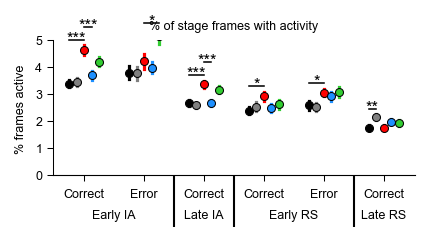

In [8]:
fig,plot_ax = plt.subplots(1,1,figsize = (2.75,1.5), layout = 'constrained')

plot_params =  {'data': trial_event_counts, 
                'errorbar':'se',
                'x':'task_phase_vec',
                'y':'prop_active_frames',
                 'order':stage_chrono_order, 'dodge' :0.5, **geno_color_dict_w_WT_CLNZ}
sc = sns.pointplot(ax = plot_ax, linestyles = 'none', **plot_params, )
ax_title = f"% of stage frames with activity"
set_ax_title_xlabel_ylabel(plot_ax, {'title':ax_title,'ylim': [0, 5], 'ylabel':  '% frames active ', 'xlabel': None, 'legend_false': True})
posthoc_df = main_run_posthoc_tests_and_get_hue_loc_df(plot_ax, plot_params, sc, comparison_list_w_WT_CLNZ, detect_error_bar = True,test_name = 'permutation_test')
plot_sig_bars_w_comp_df_tight(plot_ax,  posthoc_df.loc[posthoc_df['pvalue'] < 0.05,:])
### ANNOTATOR BLOCK END
ax_add_stage_names_and_outline_points(plot_ax)
posthoc_df['plot_name'] = ax_title
fig_name = "supp_"+"Proportion frames active per trial" 
save_fig_in_main_fig_dir(fig, fig_name= fig_name, folder_key='s_2', filetypes_to_save = ['png','svg'])
save_plot_record_as_csv_txt(posthoc_df,folder_pref:="2_s",fig_name,csv_folder_most_recent, None, csv_suffix="posthoc permutation test",txt_suffix="posthoc_text")

#### Supplementary Figure 1D- plot mean cella activity including WT CLNZ 

Saved 2_s_supp_wtclnz_pointplot_Mean event rate by phase_posthoc MWU_28_Aug_2025.csv to c:\Users\13car\Dropbox\local_github_repos_personal\dlx56_mPFC_1p_SohalLab\results\analysis_CSV_output
Output saved to c:\Users\13car\Dropbox\local_github_repos_personal\dlx56_mPFC_1p_SohalLab\results\analysis_CSV_output\2_s_supp_wtclnz_pointplot_Mean event rate by phase_posthoc_text_28_Aug_2025.txt
The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\supp_fig_2' already exists.
The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\supp_fig_2\28_Aug_2025' already exists.


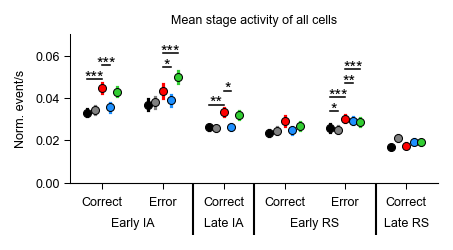

In [9]:
## hue by geno day, rows are task, phases
fig,plot_ax = plt.subplots(1,1,figsize = (3,1.65), layout = 'tight')
plot_params =  {'data': unit_mean_tseries, 'errorbar':'se', 'x':'task_phase_vec', 'y':'mean_rate','orient':'v',
                 'order':phase_list_IA_RS_chrono, 'dodge':0.5, **geno_order_w_WT_CLNZ_no_eb}

sc = sns.pointplot(ax = plot_ax, linestyles = 'none', **plot_params, )
ax_title = f"Mean stage activity of all cells"
set_ax_title_xlabel_ylabel(plot_ax, {'title':ax_title,'ylim': [0,0.07], 'ylabel':  'Norm. event/s', 'xlabel': None, 'legend_false': True})

posthoc_df = main_run_posthoc_tests_and_get_hue_loc_df(plot_ax, plot_params, sc, comparison_list_w_WT_CLNZ,detect_error_bar = True,test_name = 'MWU')
plot_sig_bars_w_comp_df_tight(plot_ax,  posthoc_df.loc[posthoc_df['pvalue'] < 0.05,:], tight_offset = 0.025)
### ANNOTATOR BLOCK END
ax_add_stage_names_and_outline_points(plot_ax)
posthoc_df['plot_name'] = ax_title
## save figs
fig_name = 'supp'+ f"_wtclnz_pointplot_Mean event rate by phase"
save_plot_record_as_csv_txt(posthoc_df,folder_pref:="2_s",fig_name,csv_folder_most_recent, None,
                                csv_suffix="posthoc MWU",txt_suffix="posthoc_text")

save_fig_in_main_fig_dir(fig, fig_name= fig_name, folder_key='s_2', filetypes_to_save = ['png'])


#### Supplement Figure 1E- WT VEH mean activation

In [10]:
unit_mean_tseries['max_timebin_index'] = unit_mean_tseries.apply(lambda x: list(numeric_col).index(x.max_val_tbin),axis = 1)

The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\fig_2' already exists.
The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\fig_2\28_Aug_2025' already exists.


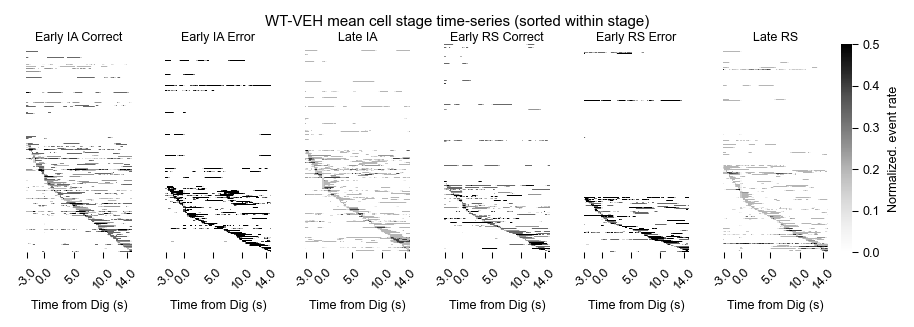

In [11]:
fig, ax_array = plt.subplots(1, len(stage_names), figsize = (6,2), layout = 'constrained', sharex = False, sharey=False,)

tseries_mat = unit_mean_tseries.loc[unit_mean_tseries.geno_day == 'WT VEH',:]
for s, task_stage in enumerate(phase_list_IA_RS_chrono):
    ax_plot = ax_array.flat[s]
    plot_df= tseries_mat.loc[tseries_mat.task_phase_vec == task_stage,:].sort_values(by = 'max_timebin_index', ascending = True).loc[:, numeric_col]
    make_cbar = s in [5]
    sns.heatmap(plot_df, ax = ax_plot,cbar_kws = {'label': f"Normalized. event rate"}, rasterized=True,cbar = make_cbar, vmax = 0.5,cmap = 'Greys',xticklabels=True)
    set_labels(ax_plot, {'title': {'label':f"{task_stage.replace("_", " ")}", 'pad':0 },'xlabel': 'Time from Dig (s)'})
    ax_plot.set_yticks([])
    # Extract existing tick labels and positions
    second_tick_to_plot = ['-3.0s','0.0s', '5.0s', '10.0s','14.0s']
    tick_positions = ax_plot.get_xticks()
    tick_labels = [tick.get_text() for tick in ax_plot.get_xticklabels()]
    filtered_ticks = [pos for pos, label in zip(tick_positions, tick_labels) if label.split(" to ")[0] in second_tick_to_plot]# Filter tick positions based on the desired labels
    filtered_labels = [label.split("s to ")[0] for label in tick_labels if label.split(" to ")[0] in second_tick_to_plot]
    # Set the filtered ticks and labels
    ax_plot.set_xticks(filtered_ticks)
    ax_plot.set_xticklabels(filtered_labels, rotation=45, ha='center')
    ax_plot.label_outer()
## save
fig.get_layout_engine().set(w_pad = 0.05, h_pad= 0.01, hspace = 0.00, wspace = 0.00)
figure_title = f"WT-VEH mean cell stage time-series (sorted within stage)"
fig.suptitle(figure_title)
## save fig
fig_name = figure_title
save_fig_in_main_fig_dir(fig, fig_name= fig_name, folder_key=2, filetypes_to_save = ['png','svg'])

#### Supplementary Figure 1F- neural stage-activation matrix with WT CLNZ include 

The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\supp_fig_2' already exists.
The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\supp_fig_2\28_Aug_2025' already exists.


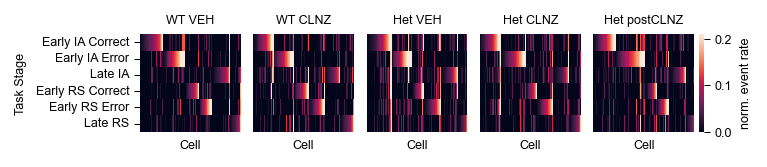

In [12]:
#plot unit heatmap for ALL GENOS
fig_mean_activity, axes = plt.subplots(1,5,figsize = (5,1), layout = 'constrained')
activity_type =  f"norm. event rate"
heatmap_clabel = activity_type

for count, geno in enumerate(geno_order_w_WT_CLNZ):
    plot_mask = (AV_matrix.geno_day == geno) & has_Early_IA_Error
    plot_data = AV_matrix.sort_values(by = ['max_phase','max_phase_val'],ascending = True).loc[plot_mask, stage_chrono_order].T
    plot_heatmap_w_kwargs(data =plot_data.rename(index = {p:p.replace("_", " ") for p in plot_data.index}), ax =axes.flat[count],
                          kwarg_dict = {
                              'vmin': min_5th_quantile, 'vmax':max_95th_quantile, 'cbar_kws': {'label': heatmap_clabel},
                              'cbar': {True: True, False: False}[count == len(geno_order_w_WT_CLNZ)-1], 'yticklabels': True, 'xticklabels':False},
                          label_dict = {'xlabel': f"Cell", 'ylabel': {False:"Task Stage", True: None}[count > 0], 'title': geno})#plot heatmap
    axes.flat[count].set_yticks({True:[], False: axes.flat[count].get_yticks()}[count > 0])
#save figs
fig_prefix = "supp_" #for sorting in folder
fig_name = 'one_row_cell stage-activity sorted heatmap'
fig_mean_activity.get_axes()
save_fig_in_main_fig_dir(fig_mean_activity, fig_name= fig_name, folder_key='s_2', filetypes_to_save = ['png'])

#### Get enrichment stats

In [13]:
unique_ID_enrichment_df = unit_mean_tseries.groupby(by = ['geno_day', 'unique_ID'])[stage_names].first()
bin_ends = get_numeric_col_bin_end_float(numeric_col)
geno_mean_enrich = unique_ID_enrichment_df.groupby('geno_day').agg({ **{p: 'mean' for p in stage_names}}).reset_index().melt(id_vars = 'geno_day', var_name = 'phase', value_name = '% enriched')
geno_mean_enrich.head()

#get long df where each row = 1 unique CELL ID and the # of stage's its enriched in
cell_num_stage_enriched_df_long = unique_ID_enrichment_df[stage_names].sum(axis = 1).sort_values().reset_index().rename(columns = {0: 'num_enrich'})
geno_cell_n_enrich_df_wide = cell_num_stage_enriched_df_long.pivot_table(columns = 'num_enrich', index =  'geno_day', aggfunc = 'count').fillna(0).divide(n_total_units, axis = 0)#pivot this to wide and collect the count of datasets doing this
geno_cell_n_enrich_df_wide.columns = geno_cell_n_enrich_df_wide.columns.get_level_values(1)
prop_of_cells_enrich_n_stages = geno_cell_n_enrich_df_wide.reset_index().melt(id_vars = 'geno_day', var_name = 'num_enrich', value_name = 'prop_enrich')
prop_of_cells_enrich_n_stages.head()

,geno_day,num_enrich,prop_enrich
0,Het CLNZ,0.0,0.632794
1,Het VEH,0.0,0.631579
2,Het postCLNZ,0.0,0.592316
3,WT CLNZ,0.0,0.651619
4,WT VEH,0.0,0.660185


#### Supplement 1G- % of cells enriched for stages

The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\supp_fig_2' already exists.
The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\supp_fig_2\28_Aug_2025' already exists.


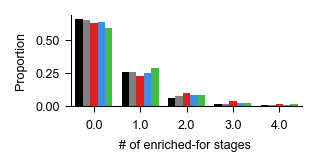

In [14]:


##plot the distribution of values + WT CLNZ
fig, ax = plt.subplots(1,1, figsize = (2,1), layout = 'constrained')
sns.barplot(prop_of_cells_enrich_n_stages, x = 'num_enrich',  y = 'prop_enrich',  **format_no_eb_w_WT_CLNZ) ## tune params
set_ax_title_xlabel_ylabel(ax, label_dict = {'title': None, 'xlim': [-0.5, 4.5], 'ylabel': f"Proportion", 'legend_false': True, 'xlabel': "# of enriched-for stages "})
make_legend = False
if make_legend:
    hand, labs = ax.get_legend_handles_labels() #pull legend from final PCA object and delete it
    fig.legend(hand, labs, bbox_to_anchor=(0.55, 1.0),loc = 'lower center', ncols = 5, frameon = True, title = 'Genotype-treatment', **legend_defaults)
#save figure
fig_prefix = "supplement_enrich_" #for sorting in folder
fig_name = "Distrib of stage enrichment count by geno-day + WT_CLNZ"
save_fig_in_main_fig_dir(fig, fig_name= fig_name, folder_key='s_2', filetypes_to_save = ['png'])

#### Supplement 1H: Cell enrichment plots (including WT CLNZ % enriched by stage)

The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\supp_fig_2' already exists.
The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\supp_fig_2\28_Aug_2025' already exists.


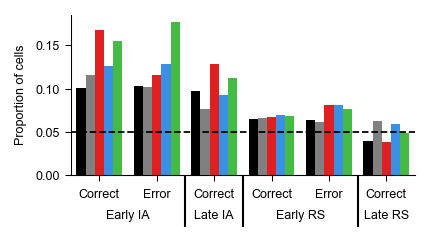

In [15]:
## plot distib of # enriched units by phase
fig, ax_prop_enrich = plt.subplots(1,1, figsize = (2.75,1.5), layout = 'constrained')
g = sns.barplot(ax =ax_prop_enrich, data =geno_mean_enrich, order = phase_list_IA_RS_chrono, x = 'phase', y = '% enriched',  **geno_color_dict_w_WT_CLNZ)
ax_prop_enrich.axhline(y = 0.05, color = 'black', linestyle = '--')
set_ax_title_xlabel_ylabel(ax_prop_enrich, {'title': None,'ylim': [0, None],'legend_false':True,  'ylabel':  f"Proportion of cells", 'xlabel': None})#f"Task Stage"}) #f' Prop. of cells active > shuffle 95%ile'
## given ordering of xposition, get the list of what ticks are belonging to what task stage
sec, sec2, is_dict = set_stage_xticks_2_layer(ax_prop_enrich, phase_list_IA_RS_chrono)
#####save fig
fig_prefix = "supplement_enrich_" #for sorting in folder
fig_name =  "% cell stage-enriched barplot_with_WT_CLNZ"
save_fig_in_main_fig_dir(fig, fig_name= fig_name, folder_key='s_2', filetypes_to_save = ['png'])

#### Supplementary Figure 1I- WT CLNZ tSNE projection

The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\supp_fig_2' already exists.
The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\supp_fig_2\28_Aug_2025' already exists.


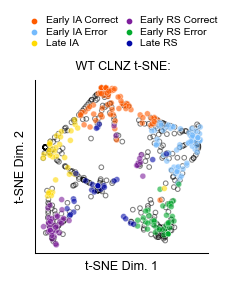

In [16]:
tsne_figsize = (1.5,1.5)
fig,ax =plt.subplots(1,1,figsize = tsne_figsize, layout = 'constrained')
transform = f"t-SNE"
## make plot
geno = 'WT CLNZ'
plot_params = dict( x = 'dim_1', y = 'dim_2',hue = 'ensemble',ax = ax) #constant across both scatters
#plot nonenriched
non_ensemble_df =  tsne_results[geno].loc[tsne_results[geno].ensemble == 'none',:]
sns.scatterplot(**plot_params, data =non_ensemble_df,   s = 5,alpha = 0.5, linewidth =0.5, legend = False, palette = ['black'],  zorder=-1000)
#find collections with > 1 point contained therein
nonlegend_collections = [x for x in ax.collections if x.get_facecolors().shape[0]>1]
collection_size= [x.get_facecolors().shape for x in nonlegend_collections]
largest_collection_size = np.max(collection_size) #use largest collection as == ensemble 
non_enrich_collection = [x for x in nonlegend_collections if x.get_facecolors().shape[0] == largest_collection_size][0]
non_enrich_collection.set_edgecolors(non_enrich_collection.get_facecolors().copy())# Restore the edge colors using the saved values
non_enrich_collection.set_facecolors("none")# Remove the face color by setting it to "none"
#plot ensemble
ensemble_df = tsne_results[geno].loc[tsne_results[geno].ensemble.isin(stage_chrono_order),:]
sns.scatterplot(**plot_params, data =ensemble_df, s = 8,alpha = 0.6, legend = True, palette = [stage_palette_dict[x] for x in stage_chrono_order], hue_order =stage_chrono_order,zorder=100 )
set_ax_title_xlabel_ylabel(ax,{'title': f" {geno} {transform}:",'ylabel': f'{transform} Dim. 2', 'xlabel': f'{transform} Dim. 1', 'xticks':[], 'yticks':[]})
#get legend and move
hand, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
fig.legend(hand, [x.replace("_", " ") for x in labels], bbox_to_anchor=(0.5, 1),loc = 'lower center', ncol = 2, frameon = False, title = None, handletextpad=0.1, )
#save fig 
ax.set_box_aspect(1)
fig_name =  f"WT CLNZ TSNE- stage activity matrix"
save_fig_in_main_fig_dir(fig, fig_name= fig_name, folder_key='s_2', filetypes_to_save = ['png'])

#### Supplement Figure 1J- plot % ensemble v nonensemble cells active on each trial

Saved 2_s_Mean % of cells active in stage that are in stage ensemble_posthoc MWU_28_Aug_2025.csv to c:\Users\13car\Dropbox\local_github_repos_personal\dlx56_mPFC_1p_SohalLab\results\analysis_CSV_output
Output saved to c:\Users\13car\Dropbox\local_github_repos_personal\dlx56_mPFC_1p_SohalLab\results\analysis_CSV_output\2_s_Mean % of cells active in stage that are in stage ensemble_posthoc_text_28_Aug_2025.txt
The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\supp_fig_2' already exists.
The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\supp_fig_2\28_Aug_2025' already exists.


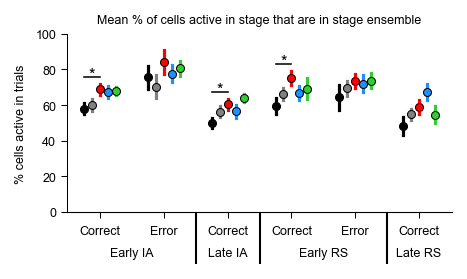

In [17]:
prop_cell_active_in_trial = trial_tseries_df_norm.groupby(by = ['name', 'geno_day', 'trial_num', 'task_phase_vec', 'enriched_in_phase'])[['active_in_trial']].mean().reset_index() #active in trial is, cell I is active in trial N
## plot % fo cells active by each ensemble embership
fig,plot_ax = plt.subplots(1,1,figsize = (3,1.75), layout = 'constrained')
e_stat_str = {True:'enriched', False: 'non-enriched'}
e_stat = 1.0
plot_mask = prop_cell_active_in_trial.enriched_in_phase == e_stat
#make plot 
plot_df = prop_cell_active_in_trial.loc[plot_mask,:].copy()
plot_df['active_in_trial'] = plot_df['active_in_trial']*100

plot_params =  {'data': plot_df,  'x':'task_phase_vec', 'y':'active_in_trial','orient':'v',
                 'order':stage_chrono_order, 'dodge': 0.5, **geno_order_w_WT_CLNZ_no_eb}
sc = sns.pointplot(ax = plot_ax, linestyles = 'none', **plot_params, errorbar = 'se')
ax_title = f"Mean % of cells active in stage that are in stage ensemble"
set_ax_title_xlabel_ylabel(plot_ax, {'title':ax_title,
                                     'ylabel':  '% cells active in trials', 
                                     'xlabel': None,
                                     'ylim': [0, 100],
                                     'legend_false': True})
posthoc_df = main_run_posthoc_tests_and_get_hue_loc_df(plot_ax, plot_params, sc, comparison_list_w_WT_CLNZ,test_name = 'MWU',detect_error_bar=True)
plot_sig_bars_w_comp_df_tight(plot_ax,  posthoc_df.loc[posthoc_df['pvalue'] < 0.05,:])
### ANNOTATOR BLOCK END
ax_add_stage_names_and_outline_points(plot_ax)
posthoc_df['plot_name'] = ax_title
#save csv
save_plot_record_as_csv_txt(posthoc_df,folder_pref:="2_s",ax_title,csv_folder_most_recent, None, csv_suffix="posthoc MWU",txt_suffix="posthoc_text")
fig_name = f"supp_Prop stage-active cell in stage ensemble" 
save_fig_in_main_fig_dir(fig, fig_name= fig_name, folder_key='s_2', filetypes_to_save = ['png','svg'])

## Figure 2 plots

#### Figure 2E- matrix of cell mean activity by task stage (dropping cells with no Early IA Error trials)

The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\fig_2' already exists.
The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\fig_2\28_Aug_2025' already exists.


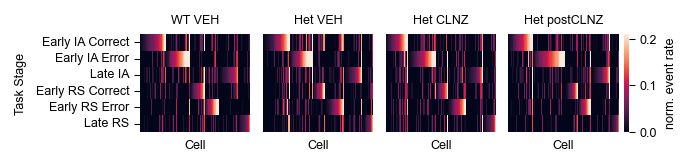

In [18]:
#plot unit heatmap for ALL GENOS
fig_mean_activity, axes = plt.subplots(1,4,figsize = (4.5,1), layout = 'constrained')
heatmap_clabel =  f"norm. event rate"
for count, geno in enumerate(geno_order):
    plot_mask = (AV_matrix.geno_day == geno) & has_Early_IA_Error
    plot_data = AV_matrix.sort_values(by = ['max_phase','max_phase_val'],ascending = True).loc[plot_mask, stage_chrono_order].T
    plot_heatmap_w_kwargs(data =plot_data.rename(index = {p:p.replace("_", " ") for p in plot_data.index}), ax =axes.flat[count],
                          kwarg_dict = { 'vmin': min_5th_quantile, 'vmax':max_95th_quantile, 'cbar_kws': {'label': heatmap_clabel},
                              'cbar': {True: True, False: False}[count == len(geno_order)-1], 'yticklabels': True, 'xticklabels':False},
                          label_dict = {'xlabel': f"Cell", 'ylabel': {False:"Task Stage", True: None}[count > 0], 'title': geno})
    axes.flat[count].set_yticks({True:[], False: axes.flat[count].get_yticks()}[count > 0])
#save figs
fig_name = 'one_row_cell stage-activity sorted heatmap'
# fig_mean_activity.get_axes()
save_fig_in_main_fig_dir(fig_mean_activity, fig_name= fig_name, folder_key=2, filetypes_to_save = ['png'])

#### Figure 2 H- TSNE projection of (mean stage activity) x (cell_ID) with Ensemble

The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\fig_2' already exists.
The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\fig_2\28_Aug_2025' already exists.


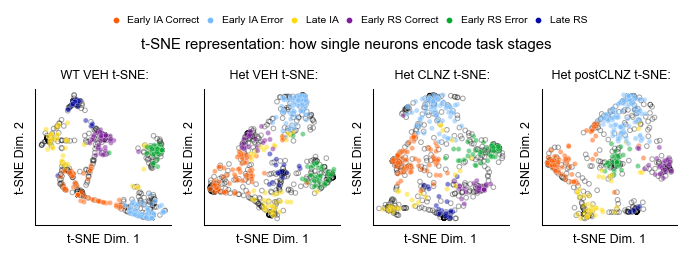

In [19]:
tsne_figsize = (4.5,1.5)
fig,ax_array =plt.subplots(1,4,figsize = tsne_figsize, layout = 'constrained')
transform = f"t-SNE"
fig.suptitle(f"t-SNE representation: how single neurons encode task stages")
## make plot
for geno_count, geno in enumerate(geno_order):#iterate through AVs to project TSNE
    ax = ax_array.flat[geno_count]
    plot_params = dict( x = 'dim_1', y = 'dim_2',hue = 'ensemble',ax = ax) #constant across both scatters
    #plot nonenriched
    non_ens_ax = ax_array.flat[geno_count]
    non_ensemble_df =  tsne_results[geno].loc[tsne_results[geno].ensemble == 'none',:]
    sns.scatterplot(**plot_params, data =non_ensemble_df,   s = 5,alpha = 0.35, linewidth =0.5, legend = False, palette = ['black'],  zorder=0)
    #find collections with > 1 point contained therein
    nonlegend_collections = [x for x in non_ens_ax.collections if x.get_facecolors().shape[0]>1]
    collection_size= [x.get_facecolors().shape for x in nonlegend_collections]
    largest_collection_size = np.max(collection_size) #use largest collection as == ensemble 
    non_enrich_collection = [x for x in nonlegend_collections if x.get_facecolors().shape[0] == largest_collection_size][0]
    non_enrich_collection.set_edgecolors(non_enrich_collection.get_facecolors().copy())# Restore the edge colors using the saved values
    non_enrich_collection.set_facecolors("none")# Remove the face color by setting it to "none"
    make_legend = geno_count == len(geno_order)-1
    
    #plot ensemble
    ensemble_df = tsne_results[geno].loc[tsne_results[geno].ensemble.isin(stage_chrono_order),:]
    sns.scatterplot(**plot_params, data =ensemble_df, s = 6,alpha = 0.5, legend = make_legend, palette = [stage_palette_dict[x] for x in stage_chrono_order], hue_order =stage_chrono_order,zorder=100 )
    set_ax_title_xlabel_ylabel(ax,{'title': f" {geno} {transform}:",'ylabel': f'{transform} Dim. 2', 'xlabel': f'{transform} Dim. 1', 'xticks':[], 'yticks':[]})
    
#get legend and move
hand, labels = ax_array.flat[-1].get_legend_handles_labels()
ax_array.flat[-1].get_legend().remove()
fig.legend(hand, [x.replace("_", " ") for x in labels], bbox_to_anchor=(0.5, 1),loc = 'lower center', ncol = 7, frameon = False, title = None, handletextpad=0.1, )
#save fig 
for ax in ax_array.flat:# force each subplot’s BOX to be square:
    ax.set_box_aspect(1)
fig_name =  f"all summary TSNE- {transform} ens mean act in task stage"

save_fig_in_main_fig_dir(fig, fig_name= fig_name, folder_key=2, filetypes_to_save = ['png'])

#### Figure 2G- % of cells enriched for each stage, inclusive


In [20]:
unique_ID_enrichment_df = unit_mean_tseries.groupby(by = ['geno_day', 'unique_ID'])[stage_names].first()
bin_ends = get_numeric_col_bin_end_float(numeric_col)
geno_mean_enrich = unique_ID_enrichment_df.groupby('geno_day').agg({ **{p: 'mean' for p in stage_names}}).reset_index().melt(id_vars = 'geno_day', var_name = 'phase', value_name = '% enriched')
geno_mean_enrich.head()

,geno_day,phase,% enriched
0,Het CLNZ,Early_IA_Correct,0.125866
1,Het VEH,Early_IA_Correct,0.168192
2,Het postCLNZ,Early_IA_Correct,0.154749
3,WT CLNZ,Early_IA_Correct,0.115800
4,WT VEH,Early_IA_Correct,0.100926


The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\fig_2' already exists.
The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\fig_2\28_Aug_2025' already exists.


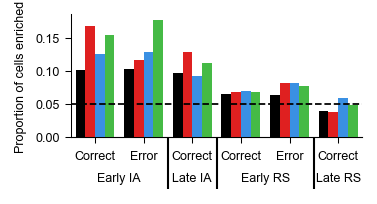

In [21]:
## plot distib of # enriched units by phase
fig, ax_prop_enrich = plt.subplots(1,1, figsize = (2.4,1.25), layout = 'constrained')
g = sns.barplot(ax =ax_prop_enrich, data =geno_mean_enrich, x = 'phase', y = '% enriched',order = phase_list_IA_RS_chrono, **geno_color_dict)
ax_prop_enrich.axhline(y = 0.05, color = 'black', linestyle = '--')
## given ordering of xposition, get the list of what ticks are belonging to what task stage
sec, sec2, is_dict = set_stage_xticks_2_layer(ax_prop_enrich, phase_list_IA_RS_chrono)
set_ax_title_xlabel_ylabel(ax_prop_enrich, {'title': None,'ylim': [0, None], 'legend_false':True, 'ylabel':  f"Proportion of cells enriched", 'xlabel': None})#f"Task Stage"}) #f' Prop. of cells active > shuffle 95%ile'
#####save fig
fig_name =  "% enriched cell for stage_ barplot"
save_fig_in_main_fig_dir(fig, fig_name= fig_name, folder_key=2, filetypes_to_save = ['png'],bbox_inches="tight",pad_inches=0)

In [22]:
##IA only enriched 
# make sum of cells enriched in IA stages vs RS stages
sum_enrich_in_geno = unique_ID_enrichment_df.reset_index(level=0).groupby(by = 'geno_day').sum()
sum_enrich_in_geno['IA_total'] = sum_enrich_in_geno['Early_IA_Correct']+  sum_enrich_in_geno['Early_IA_Error'] +  sum_enrich_in_geno['Late_IA']
sum_enrich_in_geno['RS_total'] =sum_enrich_in_geno['Early_RS_Correct']+  sum_enrich_in_geno['Early_RS_Error'] +sum_enrich_in_geno['Late_RS']
sum_enrich_in_geno

,Early_IA_Correct,Early_IA_Error,Early_RS_Correct,Early_RS_Error,Late_IA,Late_RS,IA_total,RS_total
geno_day,,,,,,,,
Het CLNZ,109.0,95.0,60.0,70.0,80.0,51.0,284.0,181.0
Het VEH,147.0,87.0,59.0,71.0,112.0,33.0,346.0,163.0
Het postCLNZ,145.0,122.0,64.0,72.0,105.0,45.0,372.0,181.0
WT CLNZ,118.0,85.0,67.0,63.0,78.0,64.0,281.0,194.0
WT VEH,109.0,90.0,70.0,69.0,105.0,42.0,304.0,181.0


#### Figure 2F- Distribution of # stages enriched for, by genotype-day

The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\fig_2' already exists.
The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\fig_2\28_Aug_2025' already exists.


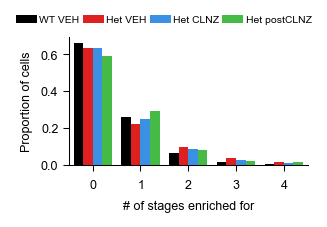

In [23]:
##plot the distribution of values
fig, ax = plt.subplots(1,1, figsize = (2,1.25), layout = 'constrained')
sns.barplot(prop_of_cells_enrich_n_stages, x = 'num_enrich',  y = 'prop_enrich',  **geno_color_dict_no_errorbar) ## tune params
set_ax_title_xlabel_ylabel(ax, label_dict = {'title': None, 'xlim': [-0.5, 4.5], 'ylabel': f"Proportion of cells", 'legend_false':True,'xlabel': "# of stages enriched for"})
ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter(useMathText=True))
hand, labs = ax.get_legend_handles_labels() #pull legend from final PCA object and delete it
fig.legend(hand, labs, bbox_to_anchor=(0.5, 1.0),loc = 'lower center', ncols =4, frameon = False, title =None, **legend_defaults)
##save fig
fig_name = "Distribution of stage enrichment counts by geno-day"
save_fig_in_main_fig_dir(fig, fig_name= fig_name, folder_key=2, filetypes_to_save = ['png'], bbox_inches="tight",pad_inches=0)

## Tabulate/plot ensembles member overlap

In [24]:
from matplotlib_venn import venn2
use_custom_venn_colors = True

In [25]:
def get_geno_stage_overlap_crosstab(input_df, ensemble_to_plot,geno_order,stage_names):
    ''' To- given a set of genotypes to iterate over, anda  dataframe with boolean (ON or OFF) in stage of interests, find the crosstabulation''' 
    set1, set2 = ensemble_to_plot        ## determine # of cells enriched in stage 1 and stage 2, and only either
    output_list = []
    for g, geno in enumerate(geno_order):
        geno_enrich_matrix = input_df.loc[input_df.geno_day==geno, :].groupby('unique_ID')[stage_names].first()
        overlap_vec = (geno_enrich_matrix[set1]==1) & (geno_enrich_matrix[set2] ==1)
        total_overlap =  overlap_vec.sum()
        set1_only_size = geno_enrich_matrix[set1].sum().astype(int) - total_overlap
        set2_only_size = geno_enrich_matrix[set2].sum().astype(int) - total_overlap
        output = dict(geno_day = geno,
                      set_1_name = set1,
                      set_2_name = set2, 
                      total_overlap = total_overlap, 
                      n_total = overlap_vec.size,
                      fraction_total_overlap = total_overlap/overlap_vec.size,
                      percent_total_overlap=100* (total_overlap/overlap_vec.size),
                      n_only_in_set_1 = set1_only_size,
                      n_only_in_set_2=set2_only_size, )
        output_list.append(output)
    geno_crosstab= pd.DataFrame.from_records(output_list)
    return geno_crosstab

def plot_ensemble_venn(ax_array, input_df, ensemble_to_plot,geno_order, stage_names, set_colors = ("r", "g"), ):
    set1, set2 = ensemble_to_plot
    venn_objs = dict()
    ## determine # of cells enriched in stage 1 and stage 2, and only either
    geno_crosstab = get_geno_stage_overlap_crosstab(input_df, ensemble_to_plot,geno_order,stage_names)

    for g, geno in enumerate(geno_order): #iterate over axes
        ax = ax_array.flat[g]
        #query pre-existing geno overlap table 
        geno_subset = geno_crosstab.loc[geno_crosstab.geno_day == geno,:]
        set1_size=geno_subset.n_only_in_set_1.values[0]
        set2_size=geno_subset.n_only_in_set_2.values[0]
        total_overlap = geno_subset.total_overlap.values[0]
        venn_objs[geno] = venn2(ax = ax, subsets = (set1_size,set2_size,total_overlap), set_colors = set_colors,
              set_labels = (replace_first_underscore_linebreak(set1), replace_first_underscore_linebreak(set2)))
        for lbl in venn_objs[geno].set_labels:
            lbl.set_fontsize(6)
        venn_title =  f"{geno}:"
        set_labels(ax, {'title':venn_title,})
    return venn_objs
#sub func
def replace_first_underscore_linebreak(input_string):
    ''' Requires N underscores with semantically meaningful breakpoint within it. Takes 1st underscore and swaps with \n'''
    pre_linebreak = input_string.split("_")[0] + "\n" 
    post_linebreak = " ".join(input_string.split("_")[1:])
    return pre_linebreak + post_linebreak

def plot_save_ensemble_overlap_fig(unit_mean_tseries,
                                   ensemble_to_plot,
                                   geno_order,
                                   stage_names,
                                   venn_fig_size, 
                                   label_text_align = {0: 'right', 1: 'center'}, 
                                   hspace = (1.5/1.5)*0.75,
                                   wspace = 0.01,
                                   fig_num = 5,
                                   **kwargs):
    
    fig, ax_array = plt.subplots(2,2,figsize =venn_fig_size, 
                                 layout = 'tight', 
                                 gridspec_kw = {'wspace':wspace,'hspace':hspace}) #(1.5/venn_fig_size[1]) is because 0.75 works for 1.5, so below that, increase spacing, and above that, decrease
    ## main venn plot info 
    set_colors = {True: tuple(stage_palette_dict[x] for x in ensemble_to_plot), False: ('r', 'g')}[use_custom_venn_colors]
    venn_objs = plot_ensemble_venn(ax_array, unit_mean_tseries, ensemble_to_plot, geno_order, stage_names,set_colors = set_colors)
    for v in venn_objs.values():
        [v.set_labels[k].set_horizontalalignment(val) for k,val in label_text_align.items()] #equiv to: # labels[0].set_horizontalalignment('right') # labels[1].set_horizontalalignment('center')
    ##save overlap fig
    fig_name = f"Ensemble cell overlap by geno for {"_".join(ensemble_to_plot)}"
    save_fig_in_main_fig_dir(fig, fig_name= fig_name, folder_key=fig_num, filetypes_to_save = ['png'])
    return fig, ax_array

In [26]:
overlap_tab = []
all_ensemble_pairs =  [['Early_IA_Correct', 'Early_RS_Correct'], ['Early_IA_Error', 'Early_RS_Error'], ['Early_IA_Correct', 'Late_IA'], ['Late_IA','Early_RS_Correct']]
for ensemble_to_plot in all_ensemble_pairs:
    overlap = get_geno_stage_overlap_crosstab(unit_mean_tseries, ensemble_to_plot,geno_order_w_WT_CLNZ,stage_names)
    overlap_tab.append(overlap)
overlap_tab = pd.concat(overlap_tab)
overlap_tab

,geno_day,set_1_name,set_2_name,total_overlap,n_total,fraction_total_overlap,percent_total_overlap,n_only_in_set_1,n_only_in_set_2
0,WT VEH,Early_IA_Correct,Early_RS_Correct,15,1080,0.013889,1.388889,94,55
1,WT CLNZ,Early_IA_Correct,Early_RS_Correct,8,1019,0.007851,0.785083,110,59
2,Het VEH,Early_IA_Correct,Early_RS_Correct,32,874,0.036613,3.661327,115,27
3,Het CLNZ,Early_IA_Correct,Early_RS_Correct,13,866,0.015012,1.501155,96,47
4,Het postCLNZ,Early_IA_Correct,Early_RS_Correct,23,937,0.024546,2.454642,122,41
0,WT VEH,Early_IA_Error,Early_RS_Error,7,1080,0.006481,0.648148,83,62
1,WT CLNZ,Early_IA_Error,Early_RS_Error,7,1019,0.006869,0.686948,78,56
2,Het VEH,Early_IA_Error,Early_RS_Error,12,874,0.013730,1.372998,75,59
3,Het CLNZ,Early_IA_Error,Early_RS_Error,10,866,0.011547,1.154734,85,60
4,Het postCLNZ,Early_IA_Error,Early_RS_Error,13,937,0.013874,1.387407,109,59


In [27]:
WT_CLNZ_overlap = overlap_tab.loc[overlap_tab.geno_day == "WT CLNZ",:].copy()
WT_CLNZ_overlap['contingency'] = WT_CLNZ_overlap.apply(lambda x: np.array([[(x.n_total-x.n_only_in_set_1-x.n_only_in_set_2-x.total_overlap), x.n_only_in_set_1], [x.n_only_in_set_2,x.total_overlap]]),axis = 1)
#contingency table: [total - only_1 - only_2 - both_1_2], only_1], [only_2, both_1_2] # resChi2ContingencyResult-    An object containing attributes:
    # statistic-float- The test statistic. # pvalue-float The p-value of the test. # dof-int: The degrees of freedom. NaN if method is not None. # expected_freq-ndarray, same shape as observed
res = WT_CLNZ_overlap.apply(lambda x: chi2_contingency(x.contingency), axis = 1,result_type = 'expand').rename({0: 'statistic', 1: 'pvalue', 2: 'dof', 3:'expected_frequency'}, axis = 1)
WT_CLNZ_overlap = pd.concat([WT_CLNZ_overlap,res],axis = 1)
## save WT CLNZ overlap info
csv_name = f"WT CLNZ chi squared on ensemble.csv"
save_csv_to_analysis_storage(posthoc_df, csv_name, csv_folder_most_recent, None)
WT_CLNZ_overlap

Saved WT CLNZ chi squared on ensemble.csv to c:\Users\13car\Dropbox\local_github_repos_personal\dlx56_mPFC_1p_SohalLab\results\analysis_CSV_output


,geno_day,set_1_name,set_2_name,total_overlap,n_total,fraction_total_overlap,percent_total_overlap,n_only_in_set_1,n_only_in_set_2,contingency,statistic,pvalue,dof,expected_frequency
1,WT CLNZ,Early_IA_Correct,Early_RS_Correct,8,1019,0.007851,0.785083,110,59,"[[842, 110], [59, 8]]",0.000000,1.000000,1,"[[841.7585868498528, 110.24141315014721], [59...."
1,WT CLNZ,Early_IA_Error,Early_RS_Error,7,1019,0.006869,0.686948,78,56,"[[878, 78], [56, 7]]",0.342918,0.558149,1,"[[876.2551521099117, 79.74484789008832], [57.7..."
1,WT CLNZ,Early_IA_Correct,Late_IA,17,1019,0.016683,1.668302,101,61,"[[840, 101], [61, 17]]",7.561281,0.005964,1,"[[832.0323846908734, 108.9676153091266], [68.9..."
1,WT CLNZ,Late_IA,Early_RS_Correct,12,1019,0.011776,1.177625,66,55,"[[886, 66], [55, 12]]",9.174917,0.002454,1,"[[879.1285574092248, 72.87144259077527], [61.8..."


#### Supplementary Figure 2A- WT CLNZ inclusive ensemble overlap

The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\supp_fig_2' already exists.
The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\supp_fig_2\28_Aug_2025' already exists.


c:\Users\13car\Dropbox\local_github_repos_personal\dlx56_mPFC_1p_SohalLab\code\Function .py Storage\helper_functions.py:165: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig_obj.savefig((save_loc / date_dir / f"{fig_name}{date_tag}.{fig_type}"), **save_args)
c:\Users\13car\anaconda3\envs\local_colab\Lib\site-packages\IPython\core\events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
c:\Users\13car\anaconda3\envs\local_colab\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


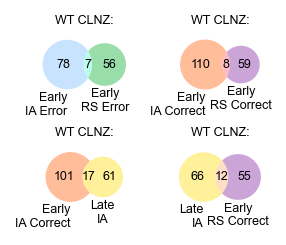

In [28]:
supplement_tag = "supp_"
stage_pairs_WT_CLNZ = [['Early_IA_Error', 'Early_RS_Error'], ['Early_IA_Correct', 'Early_RS_Correct'], ['Early_IA_Correct', 'Late_IA'], ['Late_IA','Early_RS_Correct']]
venn_fig_size = (2.1,1.5)
label_text_align = {0: 'right', 1: 'center'}  #relationship of label pos to what horz alignment to use
## make plot 
hspace = (1.5/venn_fig_size[1])*0.85
wspace = .25
fig, ax_array = plt.subplots(2,2,figsize =venn_fig_size, layout = 'tight', gridspec_kw = {'wspace':wspace,'hspace':hspace}) #(1.5/venn_fig_size[1]) is because 0.75 works for 1.5, so below that, increase spacing, and above that, decrease
for p, ensemble_to_plot in enumerate(stage_pairs_WT_CLNZ):    ## main venn plot info 
    set_colors = {True: tuple(stage_palette_dict[x] for x in ensemble_to_plot),False: ('r', 'g')}[use_custom_venn_colors]
    venn_objs = plot_ensemble_venn(np.array(ax_array.flat[p]), unit_mean_tseries,ensemble_to_plot,['WT CLNZ'], stage_names, set_colors = set_colors)
    for v in venn_objs.values():
        [v.set_labels[k].set_horizontalalignment(val) for k,val in label_text_align.items()] #equiv to: # labels[0].set_horizontalalignment('right') # labels[1].set_horizontalalignment('center')
fig_name = supplement_tag + f" WT CLNZ Ensemble overlap - all pairs"
fig_num = 's_2'
save_fig_in_main_fig_dir(fig, fig_name= fig_name, folder_key=fig_num, filetypes_to_save = ['png'])

#### Supplementary Figure 2B- get all ensemble membership overlap including WT CLNZ

In [29]:
def make_premade_comparison_pvalue_df(group_list:list, pvalue_list:list):
    ''' To, given a known pvalue for a comparison, bundle and overwrite values '''
    ## zip values together into dict
    comparison_pval_df = pd.DataFrame([dict(group_1= e[0], group_2 = e[1], pvalue=p) for e,p in zip(group_list, pvalue_list)])
    return comparison_pval_df

def update_posthoc_pvalues(posthoc_df:pd.DataFrame, comparison_pvalues:pd.DataFrame):
    #shift index to multiindex of (group1, group2) to streamline accessing
    post = posthoc_df.set_index(["group_1","group_2"])
    cmp  = comparison_pvalues.set_index(["group_1","group_2"])["pvalue"]
    post["pvalue"].update(cmp)
    #overwrite with updated values
    updated_posthoc = posthoc_df
    updated_posthoc["pvalue"] = post["pvalue"].values
    return updated_posthoc

With axis variable == Hue variable:
With axis variable == Hue variable:
With axis variable == Hue variable:
With axis variable == Hue variable:
Saved 2_s_Supplement- VEH v CLNZ for Het & WT- ensemble proportion overlap_ensemble chisquared_28_Aug_2025.csv to c:\Users\13car\Dropbox\local_github_repos_personal\dlx56_mPFC_1p_SohalLab\results\analysis_CSV_output
Output saved to c:\Users\13car\Dropbox\local_github_repos_personal\dlx56_mPFC_1p_SohalLab\results\analysis_CSV_output\2_s_Supplement- VEH v CLNZ for Het & WT- ensemble proportion overlap_ensemble chi test_28_Aug_2025.txt
The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\supp_fig_3' already exists.
The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\supp_fig_3\28_Aug_2025' already exists.


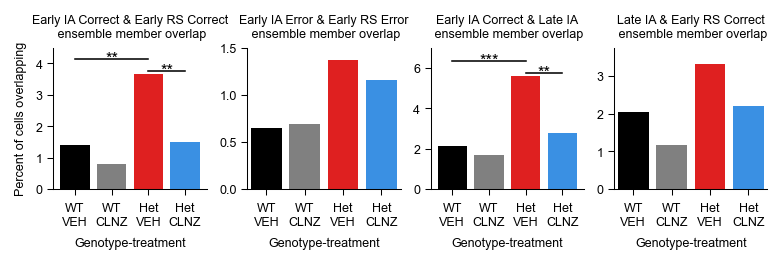

In [30]:
#decide genoplot to amke 
geno_to_plot = ["WT VEH", "WT CLNZ", "Het VEH", "Het CLNZ"]
compare_HET_v_CLNZ_in_WT_VEH= [("WT VEH", "WT CLNZ"), ("Het VEH", "Het CLNZ"), ("WT VEH", "Het VEH")]
sig_ensemble_overlap = [("WT VEH", "Het VEH"), ("Het VEH", "Het CLNZ")]
fig,ax_array = plt.subplots(1,len(all_ensemble_pairs), figsize = (5.1,1.65), layout = 'constrained')
posthoc_df_list = []
ylim_list = [4.5,1.5, 7, 3.75]
## iterate over all wt clnz comparisons
for e, ensemble_to_plot in enumerate(all_ensemble_pairs):
    ax= ax_array.flat[e]
    comparison_mask = (overlap_tab.set_1_name == ensemble_to_plot[0]).values & (overlap_tab.set_2_name == ensemble_to_plot[1]).values
    ensemble_df = overlap_tab.loc[comparison_mask,:]
    plot_df = ensemble_df.loc[ensemble_df.geno_day.isin(geno_to_plot),:]
    plot_params = dict( data =plot_df, x = 'geno_day',y = 'percent_total_overlap',dodge = False,  hue = 'geno_day', hue_order = geno_to_plot, order = geno_to_plot, palette = color_list_WT_CLNZ)
    
    sc= sns.barplot(ax=ax,**plot_params)
    ax_title= f"{" & ".join([x.replace("_", " ") for x in ensemble_to_plot])}\n ensemble member overlap"
    ylabel = {True:  "Percent of cells overlapping", False: None}
    set_labels(ax, label_dict = dict(title = ax_title, xlabel= "Genotype-treatment", ylabel = ylabel[e ==0], ylim = [0,ylim_list[e]],  legend_false = True))
    
    ##posthoc annot
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")  # This will ignore all warnings within this block       
        posthoc_df = main_run_posthoc_tests_and_get_hue_loc_df(ax, plot_params, sc, compare_HET_v_CLNZ_in_WT_VEH,test_name = 'MWU',ax_var_is_hue = True,
                                                               detect_error_bar=False,plot_type= 'barplot') # plot_sig_bars_w_comp_df_tight(plot_ax,  posthoc_df.loc[posthoc_df['pvalue'] < 0.05,:])
    chi_res = [chi2_contingency(plot_df.set_index('geno_day').loc[group,['total_overlap', 'n_total']]) for group in compare_HET_v_CLNZ_in_WT_VEH]
    ## combine into new format
    real_pvalues  = make_premade_comparison_pvalue_df(compare_HET_v_CLNZ_in_WT_VEH, [x.pvalue for x in chi_res])
    posthoc_df= update_posthoc_pvalues(posthoc_df, comparison_pvalues = real_pvalues)    ## make table with precomputed comparison p-value for overwrite  
    posthoc_df.loc[:,'category_compared_within'] = "_x_".join(ensemble_to_plot)
    posthoc_df.stat_result  = [[x.statistic, x.pvalue] for x in chi_res]
    posthoc_df.loc[:,'test_name'] = "chi_squared"
    posthoc_df_list.append(posthoc_df)
    plot_sig_bars_w_comp_df_tight(ax,  posthoc_df.loc[posthoc_df['pvalue'] < 0.05,:],tight_offset = 0.02,offset_constant=0.015)
    ax.set_xticklabels([x.get_text().replace(" ", "\n") for x in ax.get_xticklabels()])
## save it
posthoc_df = pd.concat(posthoc_df_list)
fig_name = f"Supplement- VEH v CLNZ for Het & WT- ensemble proportion overlap"
save_plot_record_as_csv_txt(posthoc_df,folder_pref:="2_s",fig_name,  csv_folder_most_recent, None, csv_suffix="ensemble chisquared",txt_suffix="ensemble chi test")
save_fig_in_main_fig_dir(fig, fig_name= fig_name, folder_key='s_3', filetypes_to_save = ['png'],bbox_inches="tight",pad_inches=0)

#### Figure 5A- Early IA/RS Error Ens overlap 

The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\fig_5' already exists.
The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\fig_5\28_Aug_2025' already exists.


c:\Users\13car\Dropbox\local_github_repos_personal\dlx56_mPFC_1p_SohalLab\code\Function .py Storage\helper_functions.py:165: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig_obj.savefig((save_loc / date_dir / f"{fig_name}{date_tag}.{fig_type}"), **save_args)
c:\Users\13car\anaconda3\envs\local_colab\Lib\site-packages\IPython\core\events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
c:\Users\13car\anaconda3\envs\local_colab\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


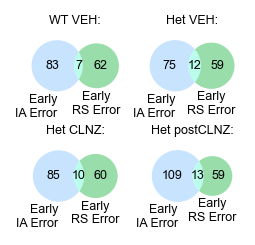

In [31]:
ensemble_to_plot = ['Early_IA_Error', 'Early_RS_Error']
venn_fig_size = (2.,1.5)
label_text_align = {0: 'right', 1: 'center'}  #relationship of label pos to what horz alignment to use
hspace = (1.5/venn_fig_size[1])*0.75

fig, ax_array = plot_save_ensemble_overlap_fig(unit_mean_tseries,
                                   ensemble_to_plot,
                                   geno_order,
                                   stage_names,
                                   venn_fig_size, 
                                   label_text_align = {0: 'right', 1: 'center'}, 
                                   hspace = (1.5/venn_fig_size[1])*0.75,
                                   fig_num = 5)

In [32]:
def plot_ensemble_percent_overlap(unit_mean_tseries, 
                                  ensemble_to_plot,
                                  stage_names,
                                  geno_order,
                                  color_list,
                                  add_sig_bars=False,
                                  add_legend = False,
                                  sig_ensemble_overlap=[], 
                                  ensemble_pvalue=[]):
    #make plot 
    geno_crosstab = get_geno_stage_overlap_crosstab(unit_mean_tseries, ensemble_to_plot,geno_order,stage_names)##now extract and plot comparison of % overlap ensemble     
    plot_params = dict( data = geno_crosstab, x = 'geno_day',y = 'percent_total_overlap',dodge = False,  hue = 'geno_day', hue_order = geno_order, order = geno_order, palette = color_list)
    sc= sns.barplot(ax=ax,**plot_params)
    ax_title= f"{" & ".join([x.replace("_", " ") for x in ensemble_to_plot])}\n ensemble membership overlap"
    set_labels(ax, label_dict = dict(title = ax_title, xlabel= "Genotype-treatment", ylabel = "Percent of cells overlapping", legend_false = True))
    posthoc_df = []
    if add_sig_bars:# get hue loc, overwrite P-value due to external chisquared
        posthoc_df = main_run_posthoc_tests_and_get_hue_loc_df(ax, plot_params, sc, preset_comparison_list,test_name = 'MWU',detect_error_bar=False,plot_type= 'barplot') # plot_sig_bars_w_comp_df_tight(plot_ax,  posthoc_df.loc[posthoc_df['pvalue'] < 0.05,:])
        posthoc_df= update_posthoc_pvalues(posthoc_df, comparison_pvalues = make_premade_comparison_pvalue_df(sig_ensemble_overlap, ensemble_pvalue))    ## make table with precomputed comparison p-value for overwrite
        plot_sig_bars_w_comp_df_tight(ax,  posthoc_df.loc[posthoc_df['pvalue'] < 0.05,:],tight_offset = 0.03,offset_constant=0.02)
    
    if add_legend:
        hand, labs =ax.get_legend_handles_labels() #pull legend from final PCA object and delete it
        plt.gcf().legend(hand, labs, bbox_to_anchor=(0.55, .975),loc = 'lower center', ncols = 4, frameon = False, title =None, **{
            'labelspacing': 0.05,
            'markerscale': 0.1,
            'borderpad': 0.0,
            'columnspacing': 0.25,
            'handletextpad': 0.15})
    
    ax.set_xticklabels([x.get_text().replace(" ", "\n") for x in ax.get_xticklabels()])
    return posthoc_df

The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\fig_5' already exists.
The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\fig_5\28_Aug_2025' already exists.


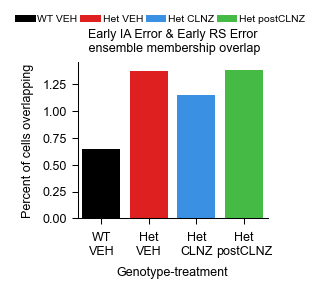

In [33]:
#new- preset pvalue due to external chi-squared calculation
add_sig_bars = False
sig_ensemble_overlap = [("WT VEH", "Het VEH"), ("Het VEH", "Het CLNZ")]
ensemble_pvalue = [1,1]
ensemble_to_plot = ['Early_IA_Error', 'Early_RS_Error']

## main fig logic
member_overlap_figsize = (1.75,1.75)
fig, ax = plt.subplots(1,1, figsize =member_overlap_figsize,layout= 'constrained')
#make plot
plot_ensemble_percent_overlap(unit_mean_tseries, ensemble_to_plot,stage_names,
                                  geno_order,color_list, add_sig_bars,
                                  add_legend = True,
                                  sig_ensemble_overlap=sig_ensemble_overlap, ensemble_pvalue= ensemble_pvalue)
##save fig 
fig_name = f"{"_".join(ensemble_to_plot)} proportion overlap"
save_fig_in_main_fig_dir(fig, fig_name= fig_name, folder_key=5, filetypes_to_save = ['png'],bbox_inches="tight",pad_inches=0)

#### Figure 6A- Early IA/RS Correct ens overlap 

The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\fig_6' already exists.
The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\fig_6\28_Aug_2025' already exists.


c:\Users\13car\Dropbox\local_github_repos_personal\dlx56_mPFC_1p_SohalLab\code\Function .py Storage\helper_functions.py:165: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig_obj.savefig((save_loc / date_dir / f"{fig_name}{date_tag}.{fig_type}"), **save_args)
c:\Users\13car\anaconda3\envs\local_colab\Lib\site-packages\IPython\core\events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
c:\Users\13car\anaconda3\envs\local_colab\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


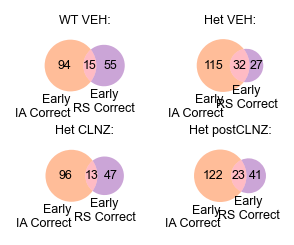

In [34]:
ensemble_to_plot = ['Early_IA_Correct', 'Early_RS_Correct']
venn_fig_size = (2.5,1.5)
label_text_align = {0: 'right', 1: 'center'}  #relationship of label pos to what horz alignment to use
hspace = (1.5/venn_fig_size[1])*0.75

fig, ax_array = plot_save_ensemble_overlap_fig(unit_mean_tseries,
                                   ensemble_to_plot,
                                   geno_order,
                                   stage_names,
                                   venn_fig_size, 
                                   label_text_align = {0: 'right', 1: 'center'}, 
                                   hspace = (1.5/venn_fig_size[1])*0.75,
                                    wspace = 0,
                                   fig_num = 6)

('xkcd:bright orange', 'xkcd:purple')
The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\fig_6' already exists.
The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\fig_6\28_Aug_2025' already exists.


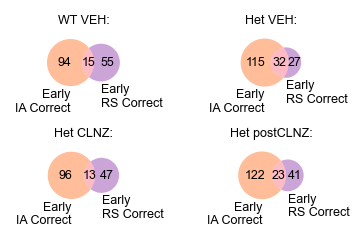

In [35]:
fig, ax_array = plt.subplots(2,2,figsize = venn_fig_size, layout = 'constrained')
ensemble_to_plot = ['Early_IA_Correct', 'Early_RS_Correct']
## main venn plot info 
set_colors = {True: tuple(stage_palette_dict[x] for x in ensemble_to_plot), False: ('r', 'g')}[use_custom_venn_colors]
print(set_colors)
plot_ensemble_venn(ax_array, unit_mean_tseries, ensemble_to_plot, geno_order, stage_names,set_colors = set_colors)
##save overlap fig
fig_name = f"Geno-days- ensemble members- {"_".join(ensemble_to_plot)} set"
save_fig_in_main_fig_dir(fig, fig_name= fig_name, folder_key=6, filetypes_to_save = ['png'])

c:\Users\13car\Dropbox\local_github_repos_personal\dlx56_mPFC_1p_SohalLab\code\Function .py Storage\plot_posthoc_test\src\plot_posthoc_test\plot_stat_annotate.py:421: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat_result = stats.mannwhitneyu(data_group_1_values, data_group_2_values)
c:\Users\13car\Dropbox\local_github_repos_personal\dlx56_mPFC_1p_SohalLab\code\Function .py Storage\plot_posthoc_test\src\plot_posthoc_test\plot_stat_annotate.py:448: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  group_mean_dict = {'group_1_mean':np.nanmean(data_group_1_values), 'group_1_sem':scipy.stats.sem(data_group_1_values,nan_policy = 'omit' ),
c:\Users\13car\Dropbox\local_github_repos_personal\dlx56_mPFC_1p_SohalLab\code\Function .py Storage\plot_posthoc_test\src\plot_posthoc_test\plot_stat_annotate.

The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\fig_6' already exists.
The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\fig_6\28_Aug_2025' already exists.


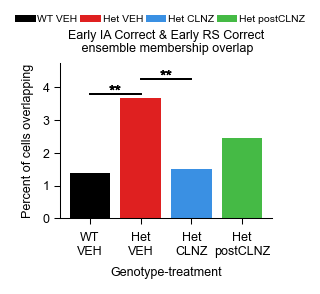

In [36]:
#new- preset pvalue due to external chi-squared calculation
add_sig_bars = True
sig_ensemble_overlap = [("WT VEH", "Het VEH"), ("Het VEH", "Het CLNZ"), ("Het VEH", "Het postCLNZ")]
ensemble_pvalue = [0.0011,0.0045]
ensemble_to_plot = ['Early_IA_Correct', 'Early_RS_Correct']
## main fig logic
fig, ax = plt.subplots(1,1, figsize =member_overlap_figsize,layout= 'constrained')
ax.set_ylim([0,4.75])
plot_ensemble_percent_overlap(unit_mean_tseries, ensemble_to_plot,stage_names,
                                  geno_order,color_list, add_sig_bars, add_legend = True,
                                  sig_ensemble_overlap=sig_ensemble_overlap, ensemble_pvalue= ensemble_pvalue)
fig_name = f"{"_".join(ensemble_to_plot)} proportion overlap"
save_fig_in_main_fig_dir(fig, fig_name= fig_name, folder_key=6, filetypes_to_save = ['png'],bbox_inches="tight",pad_inches=0)

#### Figure 7A- late IA vs. early IA correct for late IA / late IA vs. early RS correct for early RS correct 

The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\fig_7' already exists.
The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\fig_7\28_Aug_2025' already exists.


c:\Users\13car\Dropbox\local_github_repos_personal\dlx56_mPFC_1p_SohalLab\code\Function .py Storage\helper_functions.py:165: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig_obj.savefig((save_loc / date_dir / f"{fig_name}{date_tag}.{fig_type}"), **save_args)
c:\Users\13car\anaconda3\envs\local_colab\Lib\site-packages\IPython\core\events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
c:\Users\13car\anaconda3\envs\local_colab\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


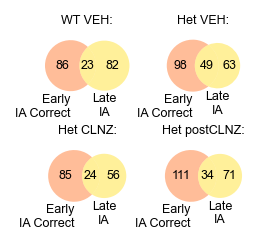

In [37]:
ensemble_to_plot = ['Early_IA_Correct', 'Late_IA']
venn_fig_size = (2.0,1.5)
label_text_align = {0: 'right', 1: 'center'}  #relationship of label pos to what horz alignment to use
hspace = (1.5/venn_fig_size[1])*0.75

fig, ax_array = plot_save_ensemble_overlap_fig(unit_mean_tseries,
                                   ensemble_to_plot,
                                   geno_order,
                                   stage_names,
                                   venn_fig_size, 
                                   label_text_align = {0: 'right', 1: 'center'}, 
                                   hspace = (1.5/venn_fig_size[1])*0.75,
                                    wspace = 0,
                                   fig_num = 7)

c:\Users\13car\Dropbox\local_github_repos_personal\dlx56_mPFC_1p_SohalLab\code\Function .py Storage\plot_posthoc_test\src\plot_posthoc_test\plot_stat_annotate.py:421: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat_result = stats.mannwhitneyu(data_group_1_values, data_group_2_values)
c:\Users\13car\Dropbox\local_github_repos_personal\dlx56_mPFC_1p_SohalLab\code\Function .py Storage\plot_posthoc_test\src\plot_posthoc_test\plot_stat_annotate.py:448: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  group_mean_dict = {'group_1_mean':np.nanmean(data_group_1_values), 'group_1_sem':scipy.stats.sem(data_group_1_values,nan_policy = 'omit' ),
c:\Users\13car\Dropbox\local_github_repos_personal\dlx56_mPFC_1p_SohalLab\code\Function .py Storage\plot_posthoc_test\src\plot_posthoc_test\plot_stat_annotate.

The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\fig_7' already exists.
The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\fig_7\28_Aug_2025' already exists.


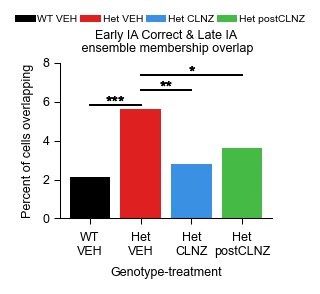

In [38]:
#preset pvalue due to external chi-squared calculation
add_sig_bars = True
sig_ensemble_overlap = [("WT VEH", "Het VEH"), ("Het VEH", "Het CLNZ"), ("Het VEH", "Het postCLNZ")]
ensemble_pvalue = [0.0001,0.004,0.032]
ensemble_to_plot = ['Early_IA_Correct', 'Late_IA']
## main fig logic
fig, ax = plt.subplots(1,1, figsize =member_overlap_figsize,layout= 'constrained')
ax.set_ylim([0,8])
plot_ensemble_percent_overlap(unit_mean_tseries, ensemble_to_plot,stage_names, geno_order,color_list, add_sig_bars,add_legend = True, sig_ensemble_overlap=sig_ensemble_overlap, ensemble_pvalue= ensemble_pvalue)
##save fig 
fig_name = f"{"_".join(ensemble_to_plot)} proportion overlap"
save_fig_in_main_fig_dir(fig, fig_name= fig_name, folder_key=7, filetypes_to_save = ['png'],bbox_inches="tight",pad_inches=0)

#### Figure 7E- early RS correct vs. late RS ensemble membership overlap

The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\fig_7' already exists.
The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\fig_7\28_Aug_2025' already exists.


c:\Users\13car\Dropbox\local_github_repos_personal\dlx56_mPFC_1p_SohalLab\code\Function .py Storage\helper_functions.py:165: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig_obj.savefig((save_loc / date_dir / f"{fig_name}{date_tag}.{fig_type}"), **save_args)
c:\Users\13car\anaconda3\envs\local_colab\Lib\site-packages\IPython\core\events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
c:\Users\13car\anaconda3\envs\local_colab\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


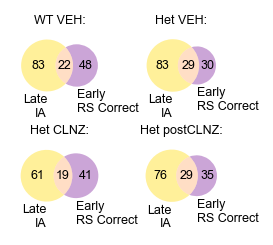

In [39]:
ensemble_to_plot = ['Late_IA','Early_RS_Correct']
venn_fig_size = (2.0,1.5)
label_text_align = {0: 'right', 1: 'left'}  #relationship of label pos to what horz alignment to use
hspace = (1.5/venn_fig_size[1])*0.75

fig, ax_array = plot_save_ensemble_overlap_fig(unit_mean_tseries,
                                   ensemble_to_plot,
                                   geno_order,
                                   stage_names,
                                   venn_fig_size, 
                                   label_text_align = label_text_align, 
                                   hspace = (1.5/venn_fig_size[1])*0.75,
                                    wspace = 0.1,
                                   fig_num = 7)


c:\Users\13car\Dropbox\local_github_repos_personal\dlx56_mPFC_1p_SohalLab\code\Function .py Storage\plot_posthoc_test\src\plot_posthoc_test\plot_stat_annotate.py:421: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat_result = stats.mannwhitneyu(data_group_1_values, data_group_2_values)
c:\Users\13car\Dropbox\local_github_repos_personal\dlx56_mPFC_1p_SohalLab\code\Function .py Storage\plot_posthoc_test\src\plot_posthoc_test\plot_stat_annotate.py:448: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  group_mean_dict = {'group_1_mean':np.nanmean(data_group_1_values), 'group_1_sem':scipy.stats.sem(data_group_1_values,nan_policy = 'omit' ),
c:\Users\13car\Dropbox\local_github_repos_personal\dlx56_mPFC_1p_SohalLab\code\Function .py Storage\plot_posthoc_test\src\plot_posthoc_test\plot_stat_annotate.

The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\fig_7' already exists.
The folder 'g:\My Drive\Colab Notebooks\Manuscript Standalone Files\results\fig_7\28_Aug_2025' already exists.


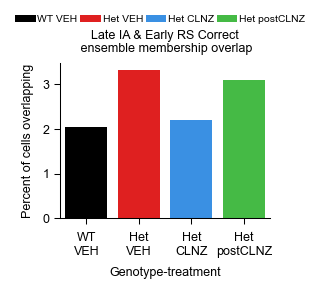

In [40]:
#new- preset pvalue due to external chi-squared calculation
add_sig_bars = True
sig_ensemble_overlap = [("WT VEH", "Het VEH"), ("Het VEH", "Het CLNZ")]
ensemble_pvalue = [0.08,0.15]
ensemble_to_plot = ['Late_IA','Early_RS_Correct']
## main fig logic
fig, ax = plt.subplots(1,1, figsize =member_overlap_figsize,layout= 'constrained')
plot_ensemble_percent_overlap(unit_mean_tseries, ensemble_to_plot,stage_names,geno_order,color_list, add_sig_bars,add_legend = True, sig_ensemble_overlap=sig_ensemble_overlap, ensemble_pvalue= ensemble_pvalue)
##save fig 
fig_name = f"{"_".join(ensemble_to_plot)} proportion overlap"
save_fig_in_main_fig_dir(fig, fig_name= fig_name, folder_key=7, filetypes_to_save = ['png'],bbox_inches="tight",pad_inches=0)